In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import ks_2samp
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import brier_score_loss

In [2]:
# Leer datos
BASE_PATH = r"C:\Users\PERSONAL\OneDrive - UNIR\Segundo Cuatrimestre\TFM\Data"

def load_folder(folder):
    folder_path = os.path.join(BASE_PATH, folder)
    print(f"\n Carpeta {folder} - Archivos encontrados: {os.listdir(folder_path)}")

    dfs = []
    for file in os.listdir(folder_path):
        if file.endswith(".xpt"):
            file_path = os.path.join(folder_path, file)
            try:
                # Usar read_xport de pandas
                df = pd.read_sas(file_path, format="xport")
                dfs.append(df)
                print(f"{file}: {df.shape[0]} filas, {df.shape[1]} columnas")
            except Exception as e:
                print(f"Error leyendo {file}: {e}")

    if dfs:
        return pd.concat(dfs, ignore_index=True, sort=False)
    else:
        raise ValueError(f"No se pudieron cargar archivos de {folder}")


In [3]:
df_demo = load_folder("DEMO")
df_alb_cr = load_folder("ALB_CR")
df_bmx = load_folder("BMX")
df_bpx = load_folder("BPX")
df_diq = load_folder("DIQ")
df_ghb = load_folder("GHB")
df_glu = load_folder("GLU")


 Carpeta DEMO - Archivos encontrados: ['DEMO_2013_2014.xpt', 'DEMO_2015_2016.xpt', 'DEMO_2017_2018.xpt', 'DEMO_2017_2020.xpt', 'DEMO_2021_2023.xpt']
DEMO_2013_2014.xpt: 10175 filas, 47 columnas
DEMO_2015_2016.xpt: 9971 filas, 47 columnas
DEMO_2017_2018.xpt: 9254 filas, 46 columnas
DEMO_2017_2020.xpt: 15560 filas, 29 columnas
DEMO_2021_2023.xpt: 11933 filas, 27 columnas

 Carpeta ALB_CR - Archivos encontrados: ['ALB_CR_2013_2014.xpt', 'ALB_CR_2015_2016.xpt', 'ALB_CR_2017_2018.xpt', 'ALB_CR_2017_2020.xpt', 'ALB_CR_2021_2023.xpt']
ALB_CR_2013_2014.xpt: 8291 filas, 6 columnas
ALB_CR_2015_2016.xpt: 8608 filas, 8 columnas
ALB_CR_2017_2018.xpt: 7936 filas, 8 columnas
ALB_CR_2017_2020.xpt: 13027 filas, 8 columnas
ALB_CR_2021_2023.xpt: 8493 filas, 8 columnas

 Carpeta BMX - Archivos encontrados: ['BMX_2013_2014.xpt', 'BMX_2015_2016.xpt', 'BMX_2017_2018.xpt', 'BMX_2017_2020.xpt', 'BMX_2021_2023.xpt']
BMX_2013_2014.xpt: 9813 filas, 26 columnas
BMX_2015_2016.xpt: 9544 filas, 26 columnas
BMX_2017_

In [4]:
# Diccionario con los dataframes
datasets = {"DEMO": df_demo, "BMX": df_bmx, "BPX": df_bpx, "ALB_CR": df_alb_cr, "DIQ": df_diq, "GHB": df_ghb, "GLU": df_glu}

# Empezamos con DEMO como base
df_final = datasets["DEMO"]

# Hacemos merge progresivo con los demás
for name, df in datasets.items():
    if name != "DEMO":  # Evitamos volver a unir DEMO consigo mismo
        df_final = df_final.merge(df, on="SEQN", how="outer")
        print(f"Merge con {name}: {df_final.shape}")

print("\nData final:", df_final.shape)


Merge con BMX: (56893, 83)
Merge con BPX: (56893, 116)
Merge con ALB_CR: (56893, 123)
Merge con DIQ: (56893, 176)
Merge con GHB: (56893, 178)
Merge con GLU: (56893, 184)

Data final: (56893, 184)


In [5]:
df = df_final.copy()

# 0. info básica
print("Shape inicial:", df.shape)
display(df.dtypes.value_counts())
print("Columnas ejemplo:", df.columns[:30])

Shape inicial: (56893, 184)


float64    183
object       1
Name: count, dtype: int64

Columnas ejemplo: Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC',
       'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL',
       'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY',
       'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ'],
      dtype='object')


In [6]:
# Normalizar nombres de columnas (minúsculas, sin espacios)
def normalize_cols(cols):
    new = []
    for c in cols:
        c2 = c.strip().lower()
        c2 = re.sub(r'[\s\-]+', '_', c2)
        c2 = re.sub(r'[^0-9a-z_]', '', c2)
        new.append(c2)
    return new

df.columns = normalize_cols(df.columns)

In [7]:
# Ver missing values

pct_thresh=0.6

def missing_report(df, pct_thresh=0.6):
    total = len(df)
    miss = df.isna().sum().sort_values(ascending=False)
    miss_pct = (miss / total).round(4)
    rep = pd.concat([miss, miss_pct], axis=1)
    rep.columns = ['n_missing', 'pct_missing']
    return rep

# Generar reporte
mr = missing_report(df)
# Mostrar las primeras columnas
display(mr.head(80))

# Filtrar las variables con más del 60% de missing
cols_high_missing = mr[mr['pct_missing'] > pct_thresh]
display(cols_high_missing)

# Mostrar cuántas son
print(f"Cantidad de variables con >60% missing: {len(cols_high_missing)}")

,n_missing,pct_missing
bmihead,56893,1.0000
diq175x,56884,0.9998
diq175w,56881,0.9998
diq175v,56856,0.9993
diq175r,56831,0.9989
...,...,...
wtph2yr,49694,0.8735
dmdeduc3,49137,0.8637
diq070,47544,0.8357
peasctm1,47385,0.8329


,n_missing,pct_missing
bmihead,56893,1.0000
diq175x,56884,0.9998
diq175w,56881,0.9998
diq175v,56856,0.9993
diq175r,56831,0.9989
...,...,...
bpxpls,35226,0.6192
bpxpty,35211,0.6189
bpacsz,35153,0.6179
bpaarm,35143,0.6177


Cantidad de variables con >60% missing: 128


In [8]:
# Eliminar columnas con más del 60% de valores faltantes menos las de pulso pues son importantes 

# Lista de columnas importantes
keep_cols = ['bpxpls', 'bpxopls1', 'bpxopls2', 'bpxopls3']

# Identifica columnas con >60% missing
cols_to_drop = df.columns[df.isna().mean() > 0.6]

# Excluye las que se quieren conservar
cols_to_drop = [c for c in cols_to_drop if c not in keep_cols]

# Elimina solo las demás
df = df.drop(columns=cols_to_drop)

print(f"Columnas eliminadas: {len(cols_to_drop)}")
print(f"Columnas restantes: {df.shape[1]}")

Columnas eliminadas: 124
Columnas restantes: 60


In [9]:
# Eliminar columnas con varianza casi nula
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(df.select_dtypes(include=['number']))
low_var_cols = df.select_dtypes(include=['number']).columns[~selector.get_support()]
df = df.drop(columns=low_var_cols)

#se eliminaron 3 quedaron 57

In [10]:
# Eliminar columnas que no aportan valor predictivo

# Lista de variables a eliminar
cols_remove = [
    'dmqmiliz',   # Sirvió en servicio activo en el ejército
    'dmdcitzn',   # Estado de ciudadanía
    'mialang',    # Idioma de la entrevista MEC
    'miaintrp',   # Intérprete utilizado para entrevista MEC
    'aialanga',   # Idioma de la entrevista de ACASI
    'dmdhhsza',   # Número de niños de 5 años o menos en el hogar
    'dmdhhszb',   # Número de niños de 6 a 17 años en el hogar
    'dmdhhsze',   # Número de adultos de 60 años o más en el hogar
    'dmdhhsiz',   # Número total de personas en el hogar
    'dmdfmsiz',   # Número total de personas en la familia
    'indhhin2',   # Ingresos anuales del hogar
    'indfmin2',    # Ingresos familiares anuales
    'fialang', 'fiaintrp', 'sialang', 'siaintrp', 'siaproxy'  # idioma / entrevista
]

# Eliminar
df = df.drop(columns=[c for c in cols_remove if c in df.columns])

#quedaron 40

In [11]:
# Limpieza: poner NaN  a los valores 7, 77, 9 y 99 pues representan respuestas inválidas o no informadas 

df['dmdeduc2'] = df['dmdeduc2'].replace({7: np.nan, 9: np.nan})

df['diq050'] = df['diq050'].replace({7: np.nan, 9: np.nan})

nhanes_missing_codes = {
    'diq160': [7, 9],
    'diq180': [7, 9],
    'diq010': [7, 9],
    'dmdborn4': [77, 99]
}

for col, codes in nhanes_missing_codes.items():
    df[col] = df[col].replace(codes, np.nan)


In [12]:
# Variables de Pulso
# 'bpxpls': 'Distribución de Pulso (frecuencia cardíaca, en latidos por minuto)'). Solo aplica 2013-2016
# 'bpxpuls':'Distribución de Pulso regular o irregular')
# 'bpxopls1': 'Distribución de Pulso oscilométrico 1era lectura')
# 'bpxopls2': 'Distribución de Pulso oscilométrico 2nda lectura'
# 'bpxopls3': 'Distribución de Pulso oscilométrico 3era lectura')

# Crear una variable con el promedio de las tres lecturas del pulso bpxopls1, bpxopls2, bpxopls3
df['pulse_osc'] = df[['bpxopls1', 'bpxopls2', 'bpxopls3']].mean(axis=1)

# Unificar en una sola variable “pulse_rate”: Combina bpxpls y pulse_osc en una única variable continua
df['pulse_rate'] = df['bpxpls'].combine_first(df['pulse_osc'])

# Lista de columnas a eliminar
cols_pulse_remove = ['pulse_osc', 'bpxopls1', 'bpxopls2', 'bpxopls3', 'bpxpuls', 'bpxpls']

df = df.drop(columns=[c for c in cols_pulse_remove if c in df.columns])

#quedaron 36

In [13]:
# Revisar si hay duplicados por SEQN
if 'seqn' in df.columns:
    dup = df.duplicated(subset=['seqn']).sum()
    print("Duplicados por SEQN:", dup)

else:
    print("No se encontró columna SEQN.")

Duplicados por SEQN: 0


In [14]:
# Detectar columnas de interés NHANES
candidatas = {
    'a1c': ['lbxgh'], # glucosa
    'urine_albumin': ['urxuma'],
    'urine_creatinine': ['urxucr'],
    'age': ['ridageyr'],
    'sex': ['riagendr'],
    'weight': ['bmxwt'],
    'height': ['bmxht'],
    'bmi': ['bmxbmi'],
    'diq': ['diq010']
}

found = {}
for key, subs in candidatas.items():
    for sub in subs:
        matches = [c for c in df.columns if sub in c]
        if matches:
            found[key] = matches[0]
            break
    else:
        found[key] = None

print("Columnas importantes:")
for k, v in found.items():
    print(f"{k:15s} -> {v}")

Columnas importantes:
a1c             -> lbxgh
urine_albumin   -> urxuma
urine_creatinine -> urxucr
age             -> ridageyr
sex             -> riagendr
weight          -> bmxwt
height          -> bmxht
bmi             -> bmxbmi
diq             -> diq010


In [15]:
# Ingeniería de variables clínicas

# Crear categorías clínicas a partir de bmxbmi (aporta Interpretabilidad, Variable categórica clínica clara)
df['bmi_cat'] = pd.cut(
    df['bmxbmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['underweight', 'normal', 'overweight', 'obese']
)

# Crear variable target: diabetes

def create_diabetes_label(row):
    """
    Crea etiqueta binaria de diabetes usando criterios NHANES / ADA:
    - DIQ010 == 1 (diagnóstico médico)
    - Glucosa en ayunas (LBXGH) >= 126 mg/dL
    """

    # 1. Autorreporte médico (NHANES DIQ010)
    try:
        if int(row['diq010']) == 1:
            return 1
    except:
        pass

    # 2. Glucosa en ayunas
    try:
        if float(row['lbxgh']) >= 126:
            return 1
    except:
        pass

    return 0

df['diabetes_label'] = df.apply(
    create_diabetes_label,
    axis=1
)

print(
    df['diabetes_label']
    .value_counts(normalize=True)
)

# 1: 8.8%

diabetes_label
0    0.911905
1    0.088095
Name: proportion, dtype: float64


In [16]:
# Crear un proxy de enfermedad renal crónica (CKD) 

def create_possible_ckd_proxy(row):
    try:
        # Creatinina urinaria elevada
        high_ur_creatinine = row['urxucr'] > 300  # umbral conservador
        
        # Actividad urinaria anómala
        abnormal_urdact = row['urdact'] > np.nanpercentile(df['urdact'], 90)
        
        # Riesgo mayor en adultos mayores
        age_risk = row['ridageyr'] >= 60
        
        if high_ur_creatinine and abnormal_urdact:
            return 1
        if age_risk and high_ur_creatinine:
            return 1
        return 0
    except:
        return np.nan

df['possible_ckd'] = df.apply(create_possible_ckd_proxy, axis=1)

print("Distribución possible_ckd:")
print(df['possible_ckd'].value_counts(normalize=True, dropna=False))

Distribución possible_ckd:
possible_ckd
0    0.994217
1    0.005783
Name: proportion, dtype: float64


In [17]:
# Selección de features para modelado

exclude = ([
    'seqn',                 # identificador
    'diabetes_label',       # target
    'possible_ckd',         # target
    'wtmec2yr', 'wtint2yr'  # pesos muestrales (no predictores) Los pesos se utilizan para análisis poblacionales, no para predicción individual.
    'sddsrvyr', 'ridstatr', 'sdmvpsu', 'sdmvstra', # Diseño muestral
    'urdact_log', 'urdact_scaled', 'urdact_imputed', # Variables auxiliares de imputación
    'miss_dmdeduc2','miss_diq050','miss_dmdhrgnd'
    ]
)

feature = [
    c for c in df.columns
    if c not in exclude
    and df[c].dtype in [np.float64, np.int64]
]

print(f"Número de variables candidatas: {len(feature)}")
print(feature)


Número de variables candidatas: 31
['sddsrvyr', 'riagendr', 'ridageyr', 'ridreth1', 'ridreth3', 'ridexmon', 'dmdborn4', 'dmdeduc2', 'dmdhrgnd', 'wtint2yr', 'indfmpir', 'bmdstats', 'bmxwt', 'bmxht', 'bmxbmi', 'bmxleg', 'bmxarml', 'bmxarmc', 'bmxwaist', 'urxuma', 'urxums', 'urxucr', 'urxcrs', 'urdact', 'urdumalc', 'diq010', 'diq160', 'diq180', 'diq050', 'lbxgh', 'pulse_rate']


In [18]:
# Definir X e y
X = df.drop(columns=exclude, errors='ignore')
y = df['diabetes_label']


In [19]:
# Lista de variables para crear indicadores de missing

missing_vars = ['diq050', 'dmdeduc2', 'dmdhrgnd', 'urdact', 'indfmpir']

for var in missing_vars:
    X[f'{var}_missing'] = X[var].isna().astype(int)


In [20]:
# train/test split (estratificado por diabetes_label)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(X_train.shape, X_test.shape)

print("Distribución en train:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en test:")
print(y_test.value_counts(normalize=True))

(45514, 37) (11379, 37)
Distribución en train:
diabetes_label
0    0.911895
1    0.088105
Name: proportion, dtype: float64

Distribución en test:
diabetes_label
0    0.911943
1    0.088057
Name: proportion, dtype: float64


In [21]:
# Variables numéricas
numeric_features = [
    'ridageyr', 'indfmpir',
    'bmxwt', 'bmxht', 'bmxbmi', 'bmxleg', 'bmxarml', 'bmxarmc', 'bmxwaist',
    'urxuma', 'urxums', 'urxucr', 'urxcrs', 'urdact', 'urdumalc',
    'lbxgh', 'pulse_rate'
]

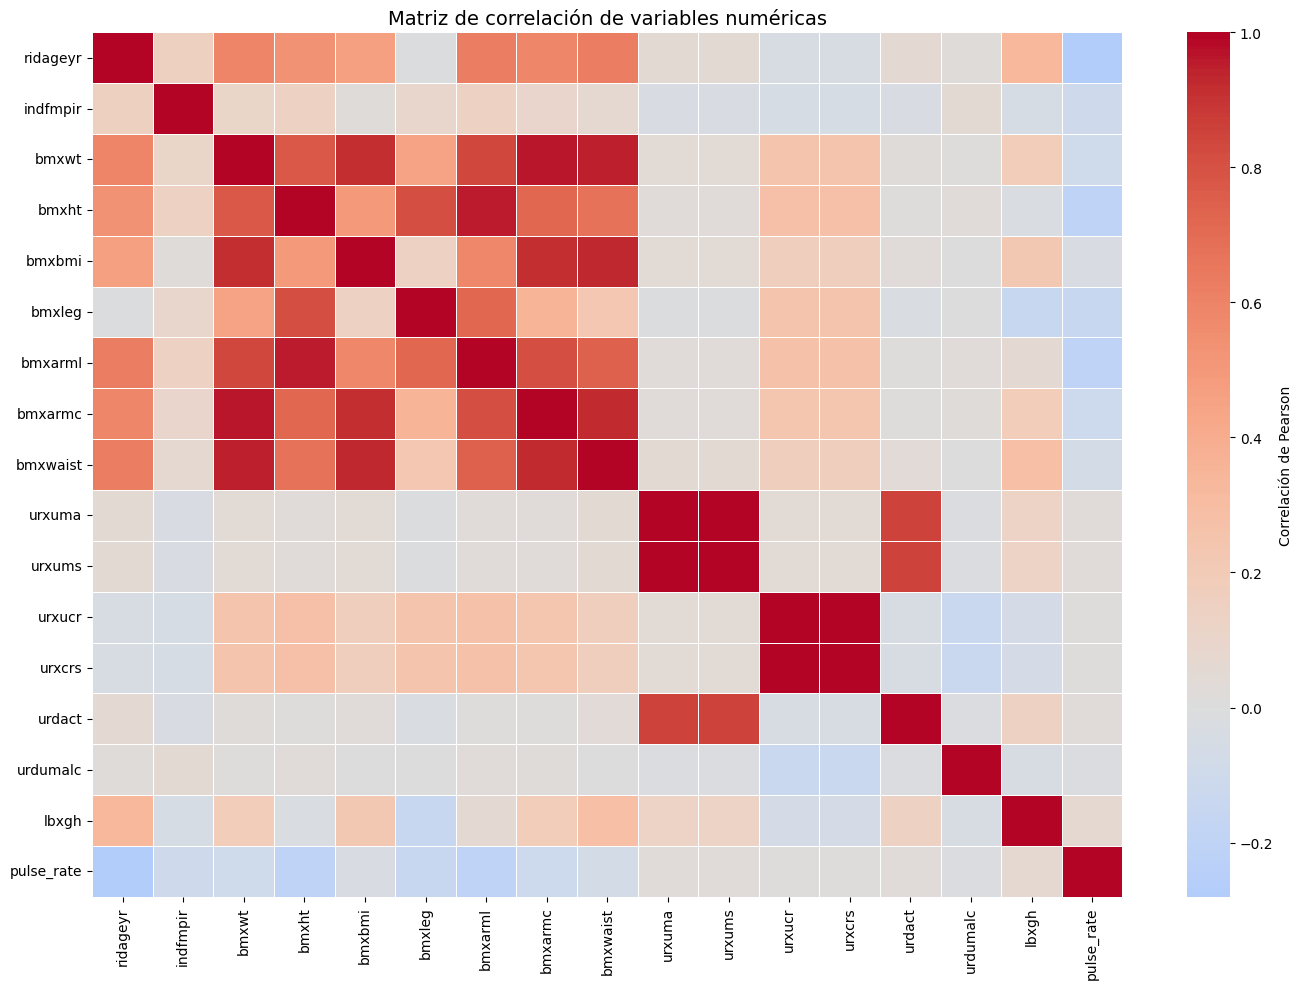

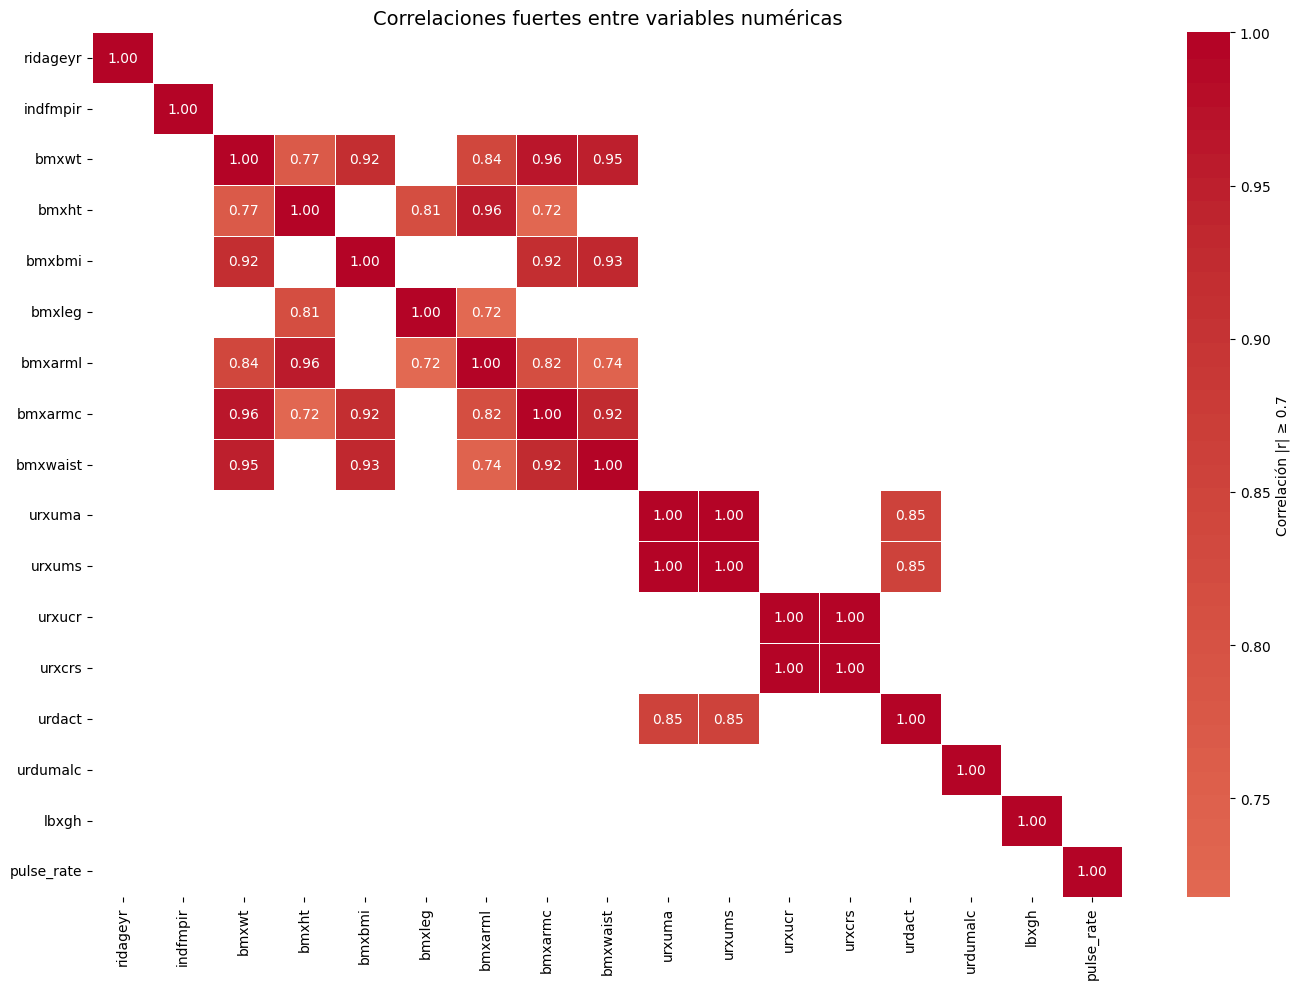

In [65]:
# Detectar colinealidad fuerte

# Matriz de correlación
corr_matrix = X[numeric_features].corr(method='pearson')

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlación de Pearson'}
)
plt.title('Matriz de correlación de variables numéricas', fontsize=14)
plt.tight_layout()
plt.show()


# Enmascarar correlaciones débiles
threshold = 0.7
corr_strong = corr_matrix.where(abs(corr_matrix) >= threshold)

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_strong,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Correlación |r| ≥ 0.7'}
)
plt.title('Correlaciones fuertes entre variables numéricas', fontsize=14)
plt.tight_layout()
plt.show()

## Imputación

In [22]:
# Ver cantidad de valores faltantes por variable

missing = X.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_table = pd.DataFrame({
    'n_missing': missing,
    'pct_missing': missing_pct.round(2)
})

print(missing_table[missing_table['n_missing'] > 0].sort_values(by='pct_missing', ascending=False))

# 28 variables con valores ausentes

            n_missing  pct_missing
diq050          26135        45.94
dmdhrgnd        23378        41.09
dmdeduc2        22861        40.18
lbxgh           21427        37.66
diq160          21387        37.59
diq180          21338        37.51
urdumalc        20318        35.71
pulse_rate      18236        32.05
bmxleg          17359        30.51
wtint2yr        15560        27.35
urxuma          12266        21.56
urxums          12266        21.56
urxucr          12266        21.56
urdact          12267        21.56
urxcrs          12266        21.56
bmxwaist        11554        20.31
bmi_cat          9469        16.64
bmxbmi           9469        16.64
bmxht            9385        16.50
bmxarmc          8397        14.76
bmxarml          8381        14.73
indfmpir         7310        12.85
bmxwt            6316        11.10
ridexmon         5672         9.97
bmdstats         5672         9.97
diq010           1952         3.43
dmdborn4           36         0.06


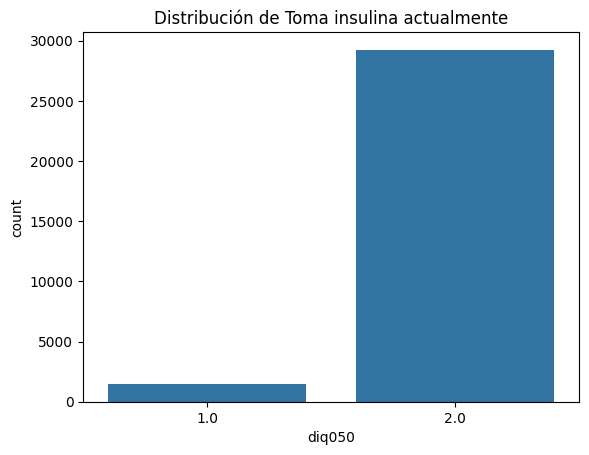

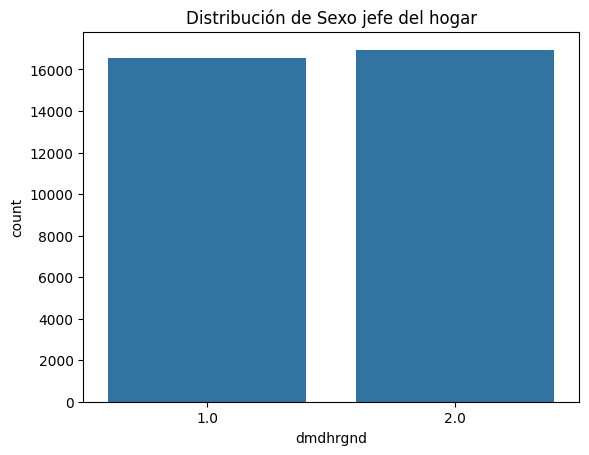

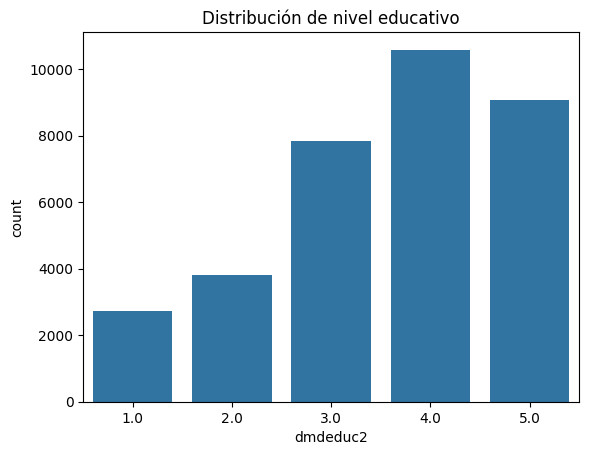

In [24]:
# Ver distribución de las 3 primeras variables a imputar: diq050, dmdhrgnd y dmdeduc2

sns.countplot(x='diq050', data=X)
plt.title('Distribución de Toma insulina actualmente')
plt.show()

sns.countplot(x='dmdhrgnd', data=X)
plt.title('Distribución de Sexo jefe del hogar')
plt.show()

sns.countplot(x='dmdeduc2', data=X)
plt.title('Distribución de nivel educativo')
plt.show()

In [23]:
X_train_orig = X_train.copy()

In [24]:
# diq050 imputación por moda
mode_diq050 = X_train['diq050'].mode()[0]

X_train['diq050'] = X_train['diq050'].fillna(mode_diq050)
X_test['diq050']  = X_test['diq050'].fillna(mode_diq050)


# Imputación de dmdhrgnd (variable con distribucion uniforme) 
# aunque esta tiene relevancia clínica casi nula, puede aportar
#  robustez sociodemográfica pero eliminarla puede reducir ruido

# Calcular proporciones
p = X_train['dmdhrgnd'].value_counts(normalize=True)

X_train['dmdhrgnd'] = X_train['dmdhrgnd'].apply(
    lambda x: np.random.choice(p.index, p=p.values) if pd.isna(x) else x
)

X_test['dmdhrgnd'] = X_test['dmdhrgnd'].apply(
    lambda x: np.random.choice(p.index, p=p.values) if pd.isna(x) else x
)

# Imputa aleatoriamente según proporción


In [27]:
# Imputación de dmdeduc2
# ============================================================
# Imputación múltiple (explorada para evaluar estabilidad)
# ------------------------------------------------------------
# Este bloque se utilizó durante el análisis metodológico
# para evaluar la variabilidad entre imputaciones y verificar
# la robustez de las distribuciones imputadas.
# 
# Para el pipeline final de modelado predictivo se utiliza
# una única imputación ajustada exclusivamente sobre el
# conjunto de entrenamiento, con el fin de evitar fuga de
# información y garantizar reproducibilidad.
# ============================================================


# def rf_probabilistic_impute(df, target, predictors, m=3, random_state=42):
#     df = df.copy()
#     miss_idx = df[df[target].isna()].index

#     imputations = []

#     for i in range(m):
#         df_i = df.copy()

#         obs = df_i[df_i[target].notna()]
#         miss = df_i[df_i[target].isna()]

#         X_train = obs[predictors]
#         y_train = obs[target].astype(int)

#         X_pred = miss[predictors]

#         # imputación simple en predictores
#         X_train = X_train.fillna(X_train.median())
#         X_pred  = X_pred.fillna(X_train.median())

#         rf = RandomForestClassifier(
#             n_estimators=200,
#             max_depth=10,
#             min_samples_leaf=50,
#             class_weight='balanced',
#             random_state=random_state + i,
#             n_jobs=2
#         )

#         rf.fit(X_train, y_train)

#         # probabilidades
#         probs = rf.predict_proba(X_pred)
#         classes = rf.classes_

#         sampled = [
#             np.random.choice(classes, p=p)
#             for p in probs
#         ]

#         df_i.loc[miss_idx, target] = sampled
#         imputations.append(df_i)

#     return imputations

# # Predictores
# educ_predictors = [
#     'ridageyr',
#     'riagendr',
#     'ridreth1',
#     'dmdborn4',
#     'indfmpir',
#     'ridexmon'
# ]

# educ_imputations = rf_probabilistic_impute(
#     df,
#     target='dmdeduc2',
#     predictors=educ_predictors,
#     m=3
# )

# # usamos una de las imputaciones
# df = educ_imputations[0]


In [25]:
# Imputación de dmdeduc2
def rf_probabilistic_impute_fit(df, target, predictors, random_state=42):
    obs = df[df[target].notna()]
    miss = df[df[target].isna()]

    X_train = obs[predictors]
    y_train = obs[target].astype(int)

    medians = X_train.median()
    X_train = X_train.fillna(medians)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=50,
        class_weight='balanced',
        random_state=random_state,
        n_jobs=2
    )

    rf.fit(X_train, y_train)
    return rf, medians

def rf_probabilistic_impute_apply(df, target, predictors, model, medians):
    df = df.copy()
    miss = df[df[target].isna()]

    if miss.empty:
        return df

    X_pred = miss[predictors].fillna(medians)
    probs = model.predict_proba(X_pred)
    classes = model.classes_

    sampled = [
        np.random.choice(classes, p=p)
        for p in probs
    ]

    df.loc[miss.index, target] = sampled
    return df

# Predictores
educ_predictors = [
    'ridageyr',
    'riagendr',
    'ridreth1',
    'dmdborn4',
    'indfmpir',
    'ridexmon'
]

rf_educ, educ_medians = rf_probabilistic_impute_fit(
    X_train,
    target='dmdeduc2',
    predictors=educ_predictors
)

X_train = rf_probabilistic_impute_apply(
    X_train, 'dmdeduc2', educ_predictors, rf_educ, educ_medians
)

X_test = rf_probabilistic_impute_apply(
    X_test, 'dmdeduc2', educ_predictors, rf_educ, educ_medians
)


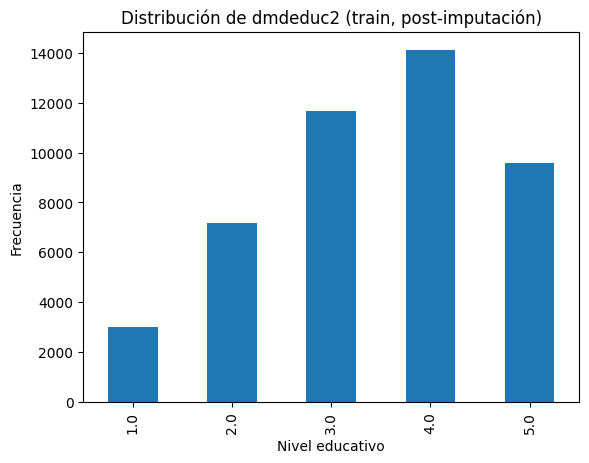

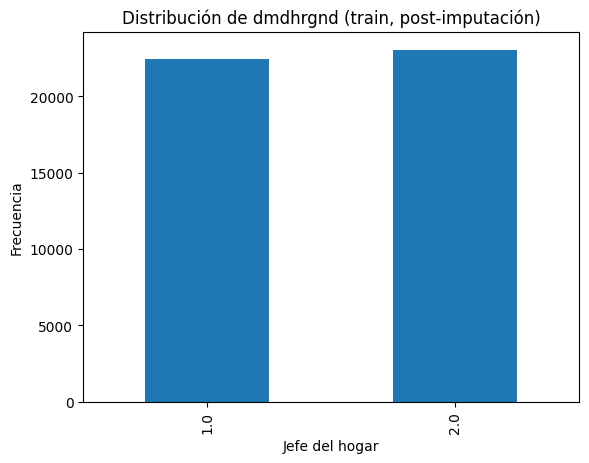

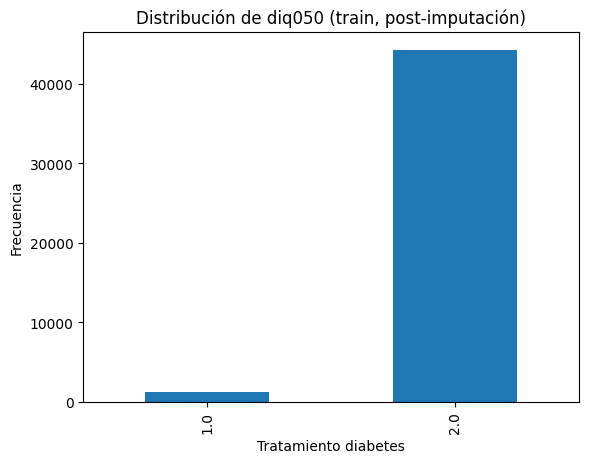

In [29]:
# Graficamos las variables imputadas

X_train['dmdeduc2'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de dmdeduc2 (train, post-imputación)')
plt.xlabel('Nivel educativo')
plt.ylabel('Frecuencia')
plt.show()

X_train['dmdhrgnd'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de dmdhrgnd (train, post-imputación)')
plt.xlabel('Jefe del hogar')
plt.ylabel('Frecuencia')
plt.show()

X_train['diq050'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de diq050 (train, post-imputación)')
plt.xlabel('Tratamiento diabetes')
plt.ylabel('Frecuencia')
plt.show()


In [26]:
# División de variables por categoría

# Biológicas
bio_cont = [
    'lbxgh', 'urdumalc', 'urxucr', 'urxuma',
    'urxcrs', 'urxums', 'urdact'
]

# Antropométricas
anthro = [
    'bmxleg', 'bmxwaist', 'bmxbmi', 'bmxht',
    'bmxarmc', 'bmxarml', 'bmxwt'
]

# Variables de peso
weights = ['wtmec2yr', 'wtint2yr']

# Categóricas
categorical = [
    'diq160', 'diq180', 'diq010',
    'ridexmon', 'bmdstats', 'dmdborn4'
]


In [27]:
# Modelo de imputación por bloques
def rf_impute_once(
    df, target, predictors,
    model_type='regression',
    random_state=42
):
    df = df.copy()

    observed = df[df[target].notna()]
    missing = df[df[target].isna()]

    if missing.empty:
        return df

    X_train = observed[predictors].copy()
    y_train = observed[target]
    X_pred = missing[predictors].copy()

    # Blindaje contra NaNs en predictores
    medians = X_train.median(numeric_only=True)
    X_train = X_train.fillna(medians)
    X_pred  = X_pred.fillna(medians)

    # Modelo
    if model_type == 'regression':
        model = RandomForestRegressor(
            n_estimators=30,
            max_depth=6,
            min_samples_leaf=100,
            max_features='sqrt',
            n_jobs=2,
            random_state=random_state
        )
    else:
        y_train = y_train.round().astype(int)

        # Eliminar clases raras
        vc = y_train.value_counts(normalize=True)
        valid = vc[vc > 0.01].index
        mask = y_train.isin(valid)

        X_train = X_train.loc[mask]
        y_train = y_train.loc[mask]

        model = RandomForestClassifier(
            n_estimators=30,
            max_depth=6,
            min_samples_leaf=100,
            max_features='sqrt',
            n_jobs=2,
            random_state=random_state
        )

    model.fit(X_train, y_train)
    preds = model.predict(X_pred)

    # Ruido SOLO regresión
    if model_type == 'regression':
        resid = y_train - model.predict(X_train)
        noise = np.random.choice(resid, size=len(preds), replace=True)
        preds = preds + noise
    else:
        preds = preds.astype(int)    

    df.loc[df[target].isna(), target] = preds
    return df


In [28]:
for var in categorical:
    print(var, df[var].dropna().unique())


diq160 [2. 1.]
diq180 [1. 2.]
diq010 [1. 2. 3.]
ridexmon [1. 2.]
bmdstats [1. 3. 2. 4.]
dmdborn4 [1. 2.]


In [29]:
# Definir las variables predictoras de cada categoría
bio_predictors = [
    'bmxwt', 'bmxbmi',
    'diq010', 'diq160', 'diq180'
]

anthro_predictors = [
    'ridageyr', 'riagendr', 'ridreth1',
    'bmxht', 'bmxwt', 'bmxbmi', 'bmxwaist'
]

weight_predictors = ['ridageyr', 'riagendr', 'ridreth1']

core_predictors = [
    'ridageyr',     # edad
    'riagendr',     # sexo
    'ridreth1',     # etnia
    'bmxbmi',       # estado corporal
    'bmxwt',
    'bmxht'
]

cat_predictors = core_predictors + [
    'lbxgh', 'bmxbmi'
]

pulse_predictors = [
    'ridageyr',
    'riagendr',
    'bmxwt',
    'bmxbmi',
    'bmxht',
    'bmxwaist'
]


indfmpir_predictors = [
    'ridageyr',
    'riagendr',
    'ridreth1',
    'bmxwt',
    'bmxbmi',
    'bmxht'
]

In [30]:
# Bloque Categóricas
for var in categorical:
    X_train = rf_impute_once(
        X_train,
        target=var,
        predictors=[v for v in cat_predictors if v != var],
        model_type='classification',
        random_state=200
    )

    X_test = rf_impute_once(
        X_test,
        target=var,
        predictors=[v for v in cat_predictors if v != var],
        model_type='classification',
        random_state=200
    )

# Bloque Antropometría
for var in anthro:
    X_train = rf_impute_once(
        X_train,
        var,
        predictors=[v for v in anthro_predictors if v != var],
        model_type='regression',
        random_state=100
    )

    X_test = rf_impute_once(
        X_test,
        var,
        predictors=[v for v in anthro_predictors if v != var],
        model_type='regression',
        random_state=100
    )

# Bloque SES (indfmpir)
X_train = rf_impute_once(
    X_train,
    'indfmpir',
    predictors=indfmpir_predictors,
    model_type='regression',
    random_state=500
)

X_test = rf_impute_once(
    X_test,
    'indfmpir',
    predictors=indfmpir_predictors,
    model_type='regression',
    random_state=500
)

# Bloque Bioquímicas sesgadas
for var in bio_cont:
    X_train = rf_impute_once(
        X_train,
        var,
        predictors=[v for v in bio_predictors if v != var],
        model_type='regression',
        random_state=42
    )

    X_test = rf_impute_once(
        X_test,
        var,
        predictors=[v for v in bio_predictors if v != var],
        model_type='regression',
        random_state=42
    )

# Bloque pulso
X_train = rf_impute_once(
    X_train,
    'pulse_rate',
    predictors=pulse_predictors,
    model_type='regression',
    random_state=400
)

X_test = rf_impute_once(
    X_test,
    'pulse_rate',
    predictors=pulse_predictors,
    model_type='regression',
    random_state=400
)


In [35]:
# M = 3
# imputed_datasets = []

# for m in range(M):
#     df_k = df.copy()

#     # Bloque CATEGÓRICO
#     for var in categorical:
#         df_k = rf_impute_once(
#             df_k,
#             var,
#             predictors=[v for v in cat_predictors if v != var],
#             model_type='classification',
#             random_state=200 + m
#         )

#     # Bloque ANTROPOMETRÍA
#     for var in anthro:
#         df_k = rf_impute_once(
#             df_k,
#             var,
#             predictors=[v for v in anthro_predictors if v != var],
#             model_type='regression',
#             random_state=100 + m
#         )

#     # BLOQUE 3: SES (indfmpir)
#     df_k = rf_impute_once(
#         df_k,
#         target='indfmpir',
#         predictors=indfmpir_predictors,
#         model_type='regression',
#         random_state=500 + m
#     )

#     # Bloque BIOQUÍMICAS SESGADAS
#     for var in bio_cont:
#         df_k = rf_impute_once(
#             df_k,
#             var,
#             predictors=[v for v in bio_predictors if v != var],
#             model_type='regression',
#             random_state=42 + m
#         )

#     # Bloque PESOS
#     for var in weights:
#         df_k = rf_impute_once(
#             df_k,
#             var,
#             predictors=[v for v in weight_predictors if v != var],
#             model_type='regression',
#             random_state=300 + m
#         )

#      # BLOQUE 6: FISIOLÓGICO
#     df_k = rf_impute_once(
#         df_k,
#         target='pulse_rate',
#         predictors=pulse_predictors,
#         model_type='regression',
#         random_state=400 + m
#     )   

#     imputed_datasets.append(df_k)

# df_imputado = imputed_datasets[0]   # usar el primer dataset imputado

In [36]:
def plot_continuous_before_after_train(X_train_orig, X_train, var):
    """
    Compara la distribución original vs imputada
    SOLO en el conjunto de entrenamiento.
    """

    plt.figure(figsize=(7, 4))

    sns.histplot(
        X_train_orig[var].dropna(),
        stat='density',
        bins=30,
        alpha=0.4,
        label='Original (train)'
    )

    sns.histplot(
        X_train[var],
        stat='density',
        bins=30,
        alpha=0.4,
        label='Imputado (train)'
    )

    plt.title(f'Antes vs después de imputación (train): {var}')
    plt.legend()
    plt.tight_layout()
    plt.show()


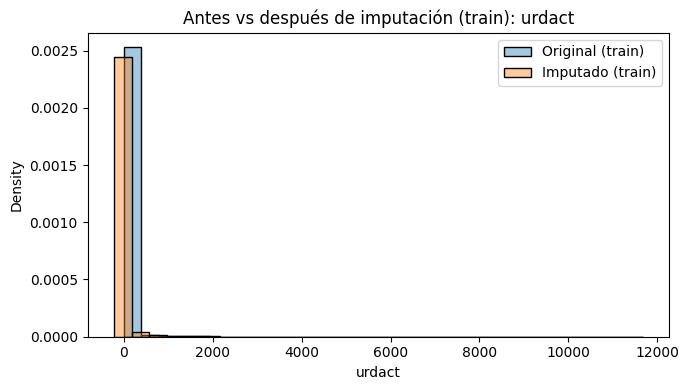

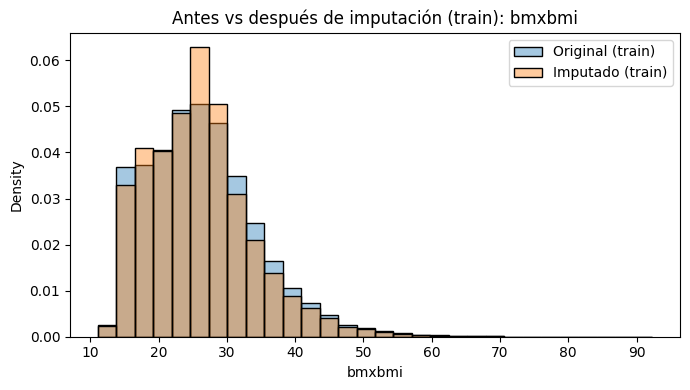

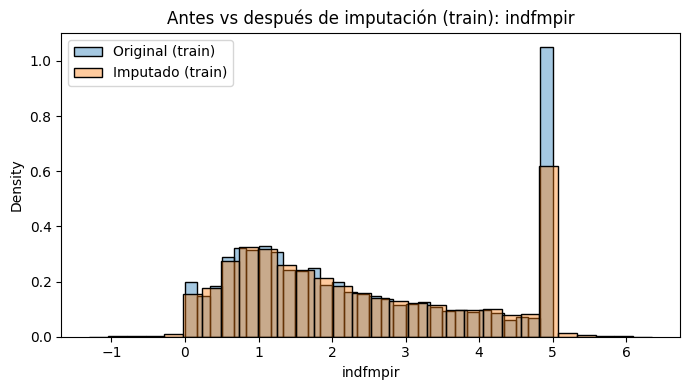

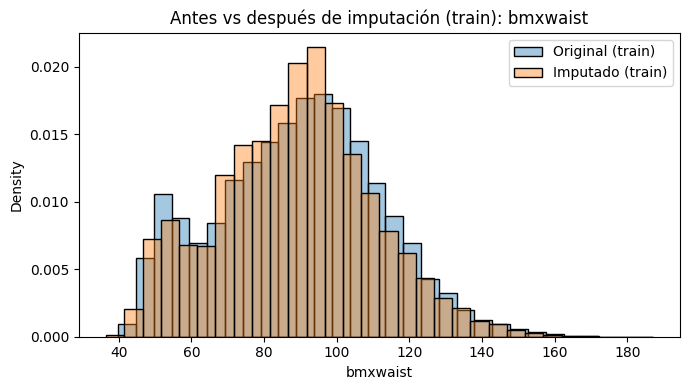

In [37]:
plot_continuous_before_after_train(X_train_orig, X_train, 'urdact')
plot_continuous_before_after_train(X_train_orig, X_train, 'bmxbmi')
plot_continuous_before_after_train(X_train_orig, X_train, 'indfmpir')
plot_continuous_before_after_train(X_train_orig, X_train, 'bmxwaist')

In [38]:
def plot_categorical_before_after(X_train_orig, X_train, var):
    orig = X_train_orig[var].value_counts(normalize=True)
    imp  = X_train[var].round().astype(int).value_counts(normalize=True)

    comp = (
        orig.rename('Original')
        .to_frame()
        .join(imp.rename('Imputado'), how='outer')
        .fillna(0)
    )

    comp.plot(kind='bar', figsize=(7,4))
    plt.title(f'Antes vs Después de imputación: {var}')
    plt.ylabel('Proporción')
    plt.xlabel(var)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


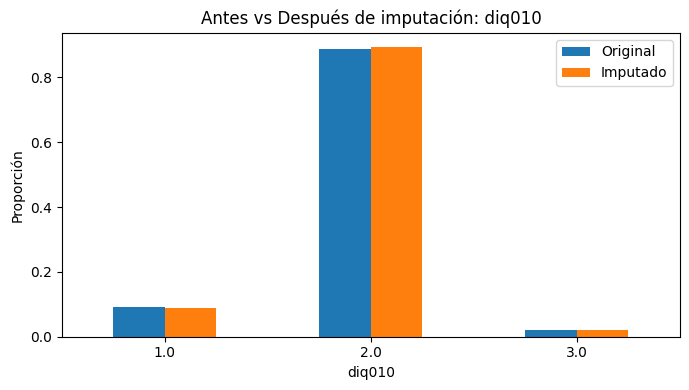

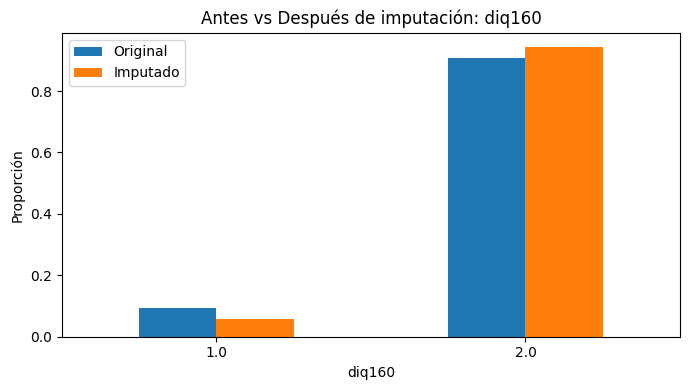

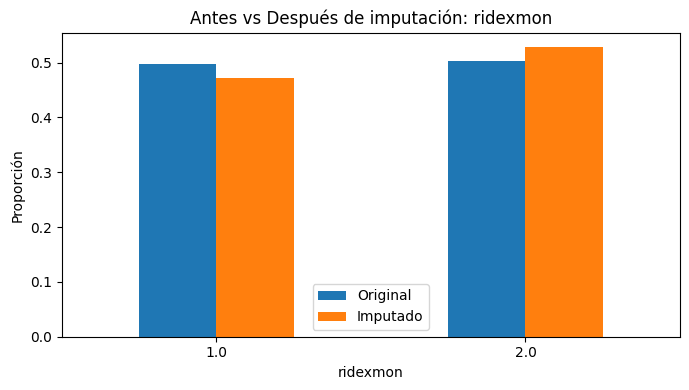

In [39]:
plot_categorical_before_after(X_train_orig, X_train, 'diq010')
plot_categorical_before_after(X_train_orig, X_train, 'diq160')
plot_categorical_before_after(X_train_orig, X_train, 'ridexmon')


In [31]:
# División de las variables en dos grupos: continuas y categóricas para evaluar las imputaciones

cont_vars = [
    'lbxgh', 'urdumalc', 'urxucr', 'urxuma',
    'urxcrs', 'urxums', 'urdact',
    'bmxleg', 'bmxwaist', 'bmxbmi', 'bmxht',
    'bmxarmc', 'bmxarml', 'bmxwt', 'wtint2yr'
]

cat_vars = [
    'diq160', 'diq180', 'diq010',
    'ridexmon', 'bmdstats', 'dmdborn4'
]

# Función para evaluar las imputaciones de las variables continuas mediante estadísticos: 
# media, mediana y prueba de kolmogorov para comparar las distribuciones 


def evaluate_continuous_train(X_train_orig, X_train_imp, var):
    orig = X_train_orig[var].dropna()
    imp  = X_train_imp[var]

    ks = ks_2samp(orig, imp)

    return {
        'variable': var,
        'mean_original': orig.mean(),
        'median_original': orig.median(),
        'mean_imputed': imp.mean(),
        'median_imputed': imp.median(),
        'ks_stat': ks.statistic
    }

def evaluate_categorical_train(X_train_orig, X_train_imp, var):
    orig = X_train_orig[var].dropna()
    imp  = X_train_imp[var]

    orig_prop = orig.value_counts(normalize=True)
    imp_prop  = imp.value_counts(normalize=True)

    # Alinear categorías
    all_cats = orig_prop.index.union(imp_prop.index)
    o = orig_prop.reindex(all_cats, fill_value=0)
    i = imp_prop.reindex(all_cats, fill_value=0)

    l1_distance = np.abs(o - i).sum()
    ent = entropy(i + 1e-8)

    return {
        'variable': var,
        'l1_distance': l1_distance,
        'entropy': ent
    }

results = []

# Continuas
for var in cont_vars:
    results.append(
        evaluate_continuous_train(X_train_orig, X_train, var)
    )

# Categóricas
for var in cat_vars:
    results.append(
        evaluate_categorical_train(X_train_orig, X_train, var)
    )

results_df = pd.DataFrame(results)
results_df


,variable,mean_original,median_original,mean_imputed,median_imputed,ks_stat,l1_distance,entropy
0,lbxgh,5.731238,5.500000e+00,5.612911,5.400000e+00,0.077111,NaN,NaN
1,urdumalc,0.013485,5.397605e-79,0.013323,5.397605e-79,0.176210,NaN,NaN
2,urxucr,125.232504,1.090000e+02,120.073836,1.045828e+02,0.025403,NaN,NaN
3,urxuma,42.460157,9.200000e+00,39.201320,8.545892e+00,0.077680,NaN,NaN
4,urxcrs,11070.553327,9.635600e+03,10624.742171,9.282000e+03,0.024801,NaN,NaN
5,urxums,42.460157,9.200000e+00,38.624467,8.500000e+00,0.077900,NaN,NaN
6,urdact,40.087867,8.130000e+00,38.513615,8.360000e+00,0.046120,NaN,NaN
7,bmxleg,38.453537,3.850000e+01,37.383856,3.780000e+01,0.079563,NaN,NaN
8,bmxwaist,89.363766,9.040000e+01,88.553275,8.930000e+01,0.046881,NaN,NaN
9,bmxbmi,26.441502,2.560000e+01,26.059946,2.553378e+01,0.042406,NaN,NaN


In [32]:
results_df_round = results_df.copy()
results_df_round = results_df_round.round(3)

In [33]:
# Re imputar urdact

X_train['urdact'] = X_train_orig['urdact']
X_train['urdact_log'] = np.log1p(X_train['urdact'])

urdact_predictors = [
    'urxucr',      # creatinina urinaria
    'urxuma',      # albúmina urinaria
    'urxums',
    'lbxgh',       # glucosa
    'bmxbmi',
    'bmxwt',
    'ridageyr',
    'riagendr',
    'indfmpir'
]

# Transformar la variable urdact si es sesgada
X_train['urdact_log'] = np.log1p(X_train['urdact']) # Si 'urdact' tiene valores muy pequeños o ceros

# Normalizar
scaler = StandardScaler()
X_train['urdact_scaled'] = scaler.fit_transform(X_train[['urdact_log']])

# Imputación
X_train = rf_impute_once(
    X_train,
    target='urdact_scaled',  # Imputar con la versión escalada
    predictors=[v for v in urdact_predictors if v != 'urdact_scaled'],
    model_type='regression',
    random_state=500
)

# Revertir la transformación
X_train['urdact_imputed'] = np.expm1(X_train['urdact_scaled'])

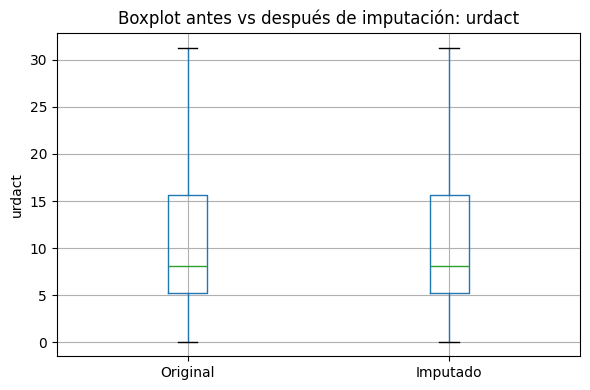

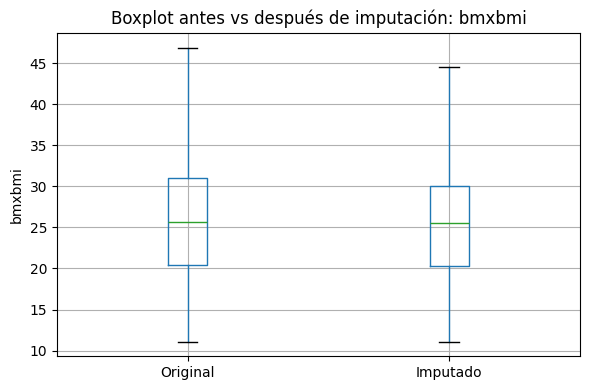

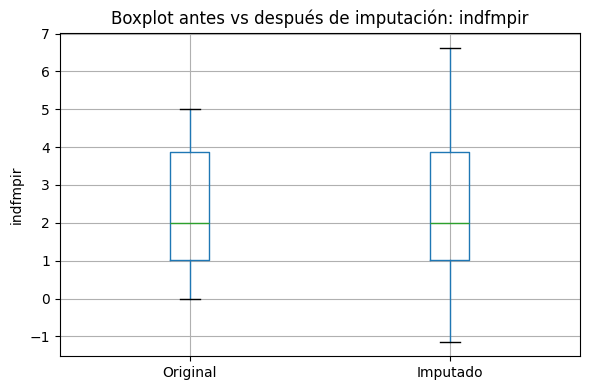

In [34]:
# Graficamos boxplots para comparar
vars_boxplot = ['urdact', 'bmxbmi', 'indfmpir']

for var in vars_boxplot:
    data = pd.DataFrame({
        'Original': X_train_orig[var],
        'Imputado': X_train[var]
    })

    plt.figure(figsize=(6, 4))
    data.boxplot(showfliers=False)
    plt.title(f'Boxplot antes vs después de imputación: {var}')
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()


## Modelado

In [35]:
# Codificación de categóricas 

# Variables numéricas reales
numeric_features = [
    'ridageyr', 'indfmpir',
    'bmxwt', 'bmxht', 'bmxbmi', 'bmxleg', 'bmxarml', 'bmxarmc', 'bmxwaist',
    'urxuma', 'urxums', 'urxucr', 'urxcrs', 'urdact', 'urdumalc',
    'lbxgh', 'pulse_rate', 'urdact_missing', 'indfmpir_missing'
]

# Variables categóricas
categorical_features = [
    'riagendr', 'ridreth1', 'ridreth3', 'ridexmon',
    'dmdborn4', 'dmdeduc2', 'dmdhrgnd',
    'bmdstats',
    'diq010', 'diq160', 'diq180', 'diq050',
    'bmi_cat'
]

# pipeline de preprocesado

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # seguridad
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',        # evita colinealidad
        sparse_output=False
    ))
])

preprocessor_base = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [36]:
# Modelo base

rf_model_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=50,
    class_weight='balanced',
    n_jobs=2,
    random_state=42
)


In [37]:
# Pipeline completo (preprocesamiento + modelo)
rf_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('model', rf_model_base)
])


In [38]:
# Entrenamiento

rf_pipeline_base.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
X_train = X_train.drop(columns=['urdact_log', 'urdact_scaled'])
X_train['urdact'] = X_train['urdact_imputed']
X_train = X_train.drop(columns=['urdact_imputed'])
X_train.columns

Index(['sddsrvyr', 'riagendr', 'ridageyr', 'ridreth1', 'ridreth3', 'ridexmon',
       'dmdborn4', 'dmdeduc2', 'dmdhrgnd', 'wtint2yr', 'indfmpir', 'bmdstats',
       'bmxwt', 'bmxht', 'bmxbmi', 'bmxleg', 'bmxarml', 'bmxarmc', 'bmxwaist',
       'urxuma', 'urxums', 'urxucr', 'urxcrs', 'urdact', 'urdumalc', 'diq010',
       'diq160', 'diq180', 'diq050', 'lbxgh', 'pulse_rate', 'bmi_cat',
       'diq050_missing', 'dmdeduc2_missing', 'dmdhrgnd_missing',
       'urdact_missing', 'indfmpir_missing'],
      dtype='object')

In [40]:
X_test.columns

Index(['sddsrvyr', 'riagendr', 'ridageyr', 'ridreth1', 'ridreth3', 'ridexmon',
       'dmdborn4', 'dmdeduc2', 'dmdhrgnd', 'wtint2yr', 'indfmpir', 'bmdstats',
       'bmxwt', 'bmxht', 'bmxbmi', 'bmxleg', 'bmxarml', 'bmxarmc', 'bmxwaist',
       'urxuma', 'urxums', 'urxucr', 'urxcrs', 'urdact', 'urdumalc', 'diq010',
       'diq160', 'diq180', 'diq050', 'lbxgh', 'pulse_rate', 'bmi_cat',
       'diq050_missing', 'dmdeduc2_missing', 'dmdhrgnd_missing',
       'urdact_missing', 'indfmpir_missing'],
      dtype='object')

In [40]:
# Evaluación

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

y_pred_base = rf_pipeline_base.predict(X_test)
y_prob_base = rf_pipeline_base.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_base))
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base))
print("Recall (Sensibilidad):", recall_score(y_test, y_pred_base))
print("F1:", f1_score(y_test, y_pred_base))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_base))


ROC-AUC: 0.9998519872657115
Accuracy: 0.9927937428596537
Precision: 0.9275092936802974
Recall (Sensibilidad): 0.9960079840319361
F1: 0.960538979788258

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10377
           1       0.93      1.00      0.96      1002

    accuracy                           0.99     11379
   macro avg       0.96      0.99      0.98     11379
weighted avg       0.99      0.99      0.99     11379



In [41]:
# Excluyendo:
# lbxgh = HbA1c (hemoglobina glicosilada)
# diq10

# Eliminar definitivamente de X
leakage_vars = ['diq010', 'lbxgh']

X = X.drop(columns=leakage_vars, errors='ignore')
X_train = X_train.drop(columns=leakage_vars, errors='ignore')
X_test = X_test.drop(columns=leakage_vars, errors='ignore')

numeric_features = [
    v for v in numeric_features
    if v != 'lbxgh'
]

categorical_features = [
    v for v in categorical_features
    if v != 'diq010'
]

# pipeline de preprocesado

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',        
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=50,
    class_weight='balanced',
    n_jobs=2,
    random_state=42
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall (Sensibilidad):", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

ROC-AUC: 0.9510473127177272
Accuracy: 0.854908164162053
Precision: 0.37128123760412535
Recall (Sensibilidad): 0.9341317365269461
F1: 0.5313653136531366

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     10377
           1       0.37      0.93      0.53      1002

    accuracy                           0.85     11379
   macro avg       0.68      0.89      0.72     11379
weighted avg       0.94      0.85      0.88     11379



In [42]:
rf_pipeline.named_steps['preprocessor'].get_feature_names_out()


array(['num__ridageyr', 'num__indfmpir', 'num__bmxwt', 'num__bmxht',
       'num__bmxbmi', 'num__bmxleg', 'num__bmxarml', 'num__bmxarmc',
       'num__bmxwaist', 'num__urxuma', 'num__urxums', 'num__urxucr',
       'num__urxcrs', 'num__urdact', 'num__urdumalc', 'num__pulse_rate',
       'num__urdact_missing', 'num__indfmpir_missing',
       'cat__riagendr_2.0', 'cat__ridreth1_2.0', 'cat__ridreth1_3.0',
       'cat__ridreth1_4.0', 'cat__ridreth1_5.0', 'cat__ridreth3_2.0',
       'cat__ridreth3_3.0', 'cat__ridreth3_4.0', 'cat__ridreth3_6.0',
       'cat__ridreth3_7.0', 'cat__ridexmon_2.0', 'cat__dmdborn4_2.0',
       'cat__dmdeduc2_2.0', 'cat__dmdeduc2_3.0', 'cat__dmdeduc2_4.0',
       'cat__dmdeduc2_5.0', 'cat__dmdhrgnd_2.0', 'cat__bmdstats_2.0',
       'cat__bmdstats_3.0', 'cat__bmdstats_4.0', 'cat__diq160_2.0',
       'cat__diq180_2.0', 'cat__diq050_2.0', 'cat__bmi_cat_obese',
       'cat__bmi_cat_overweight', 'cat__bmi_cat_underweight'],
      dtype=object)

In [44]:
# Validación cruzada anidada

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

param_grid = {
    'model__n_estimators': [200, 300],
    'model__max_depth': [8, 10],
    'model__min_samples_leaf': [30, 50]
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=2
    ))
])


param_grid = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [5, 10, None],
    'model__min_samples_leaf': [20, 50, 100]
}


inner_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=inner_cv,
    n_jobs=2,
    error_score='raise'
)

from sklearn.model_selection import cross_val_score

nested_auc = cross_val_score(
    estimator=inner_search,
    X=X,
    y=y,
    cv=outer_cv,
    scoring='roc_auc',
    n_jobs=2
)

print("AUC medio (nested CV):", nested_auc.mean())
print("Desviación estándar:", nested_auc.std())


AUC medio (nested CV): 0.9709281439937195
Desviación estándar: 0.0010094048630139632


In [43]:
# Brier score: qué tan buenas son las probabilidades predichas

brier = brier_score_loss(y_test, y_prob)
print("Brier score:", brier)


Brier score: 0.11312329157742254


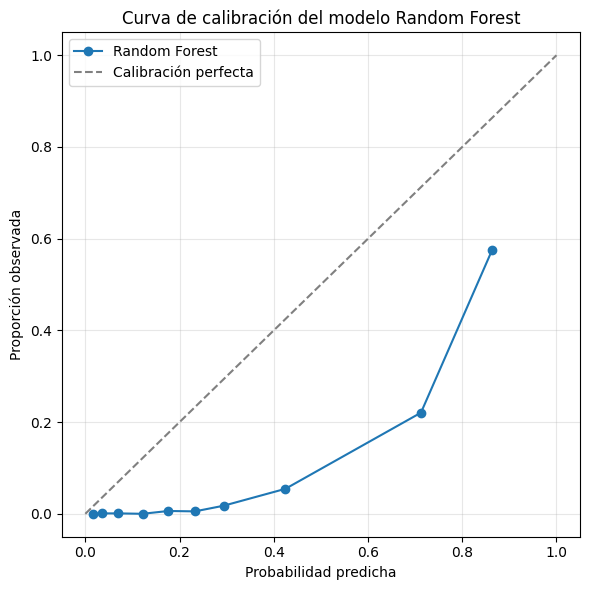

In [88]:
# Curva de calibración

from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    y_test, y_prob, n_bins=10, strategy='quantile'
)

plt.figure(figsize=(6,6))

plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Calibración perfecta')

plt.xlabel('Probabilidad predicha')
plt.ylabel('Proporción observada')
plt.title('Curva de calibración del modelo Random Forest')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [89]:
from sklearn.calibration import CalibratedClassifierCV

rf_cal = CalibratedClassifierCV(rf_pipeline, method='isotonic', cv=5)

rf_cal.fit(X_train, y_train)
y_prob_cal = rf_cal.predict_proba(X_test)[:,1]


In [90]:

brier_orig = brier_score_loss(y_test, y_prob)
brier_cal  = brier_score_loss(y_test, y_prob_cal)

print("Brier original:", brier_orig)
print("Brier calibrado:", brier_cal)


Brier original: 0.11156803173286475
Brier calibrado: 0.045584303701998764


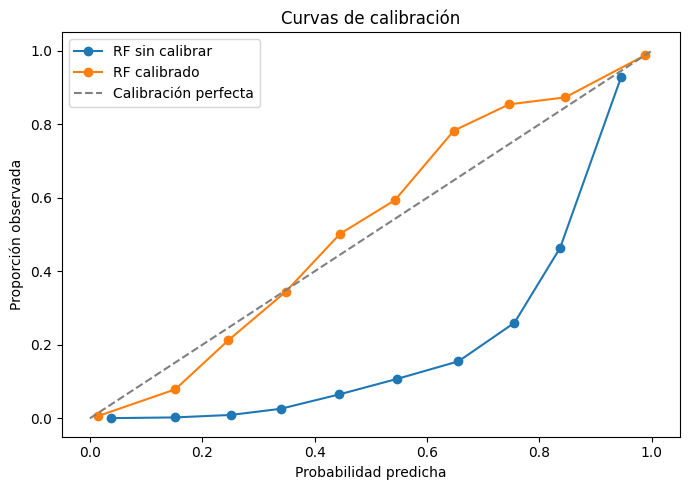

In [49]:


prob_true_orig, prob_pred_orig = calibration_curve(
    y_test, y_prob, n_bins=10
)

prob_true_cal, prob_pred_cal = calibration_curve(
    y_test, y_prob_cal, n_bins=10
)

plt.figure(figsize=(7,5))
plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='RF sin calibrar')
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='RF calibrado')
plt.plot([0,1], [0,1], '--', color='gray', label='Calibración perfecta')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Proporción observada')
plt.title('Curvas de calibración')
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
print("AUC original:", roc_auc_score(y_test, y_prob))
print("AUC calibrado:", roc_auc_score(y_test, y_prob_cal))


AUC original: 0.9503069605224359
AUC calibrado: 0.969243069224373


In [91]:
# Regresión logística - Modelo baseline

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

log_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', log_model)
])

log_pipeline.fit(X_train, y_train)

y_prob_log = log_pipeline.predict_proba(X_test)[:,1]
y_pred_log = log_pipeline.predict(X_test)


In [92]:
print("Regresión Logística")
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))
print("Recall (Sensibilidad):", recall_score(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("F1-score:", f1_score(y_test, y_pred_log))
print("Brier Score:", brier_score_loss(y_test, y_prob_log))


Regresión Logística
ROC-AUC: 0.944821833638303
Recall (Sensibilidad): 0.9590818363273453
Accuracy: 0.8146585815976799
Precision: 0.3172664245625619
F1-score: 0.4768047630860829
Brier Score: 0.13129540901058695


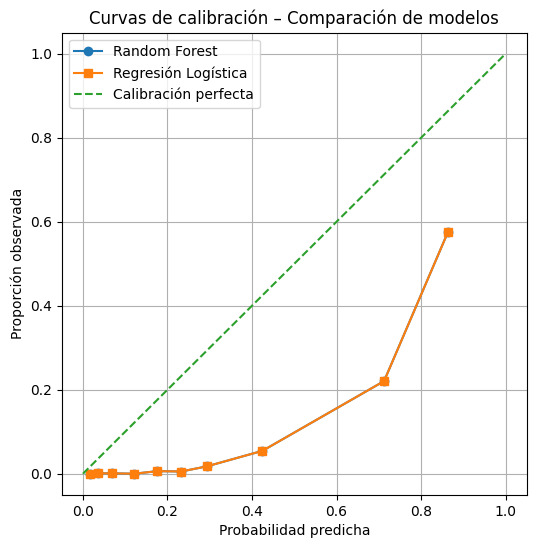

In [93]:
# Comparacion con RF sin calibrar
prob_true_rf, prob_pred_rf = calibration_curve(
    y_test,
    y_prob,
    n_bins=10,
    strategy='quantile'
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='Random Forest')
plt.plot(prob_pred, prob_true, marker='s', label='Regresión Logística')
plt.plot([0, 1], [0, 1], linestyle='--', label='Calibración perfecta')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Proporción observada')
plt.title('Curvas de calibración – Comparación de modelos')
plt.legend()
plt.grid(True)
plt.show()


In [97]:
# Calibración de Regresión logística

log_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # OneHot + imputación
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs'
    ))
])

log_cal = CalibratedClassifierCV(
    estimator=log_pipeline,
    method='isotonic',
    cv=5
)

log_cal.fit(X_train, y_train)

y_prob_log_cal = log_cal.predict_proba(X_test)[:, 1]


print("Regresión Logística calibrada")
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log_cal))
print("Brier Score:", brier_score_loss(y_test, y_prob_log_cal))

Regresión Logística calibrada
ROC-AUC: 0.9448828564322641
Brier Score: 0.054029377546488906


In [98]:
# Modelo XGBoost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=2
)


In [99]:
# Pipeline
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_model)
    ]
)

# Entrenamiento
xgb_pipeline.fit(X_train, y_train)

# Predicciones
# Probabilidades
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Predicciones binarias (umbral 0.5)
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

# Métricas

print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("Recall (Sensibilidad):", recall_score(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("F1-score:", f1_score(y_test, y_pred_xgb))


ROC-AUC: 0.9553251596450542
Recall (Sensibilidad): 0.6776447105788423
Accuracy: 0.934967923367607
Precision: 0.6195255474452555
F1-score: 0.6472831267874166


In [100]:
# brier_score
print("Brier Score:", brier_score_loss(y_test, y_prob_xgb))


Brier Score: 0.044732814497940136


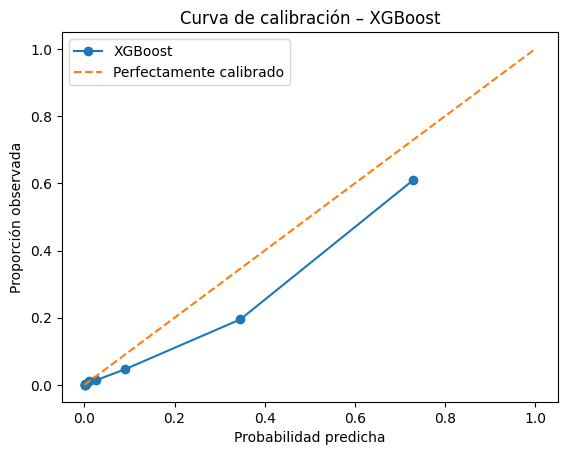

In [101]:
# Curva de calibración (XGBoost sin calibrar)

prob_true, prob_pred = calibration_curve(
    y_test,
    y_prob_xgb,
    n_bins=10,
    strategy="quantile"
)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0,1], [0,1], linestyle='--', label='Perfectamente calibrado')
plt.xlabel("Probabilidad predicha")
plt.ylabel("Proporción observada")
plt.title("Curva de calibración – XGBoost")
plt.legend()
plt.show()


In [102]:
# Calibración de XGBoost
from sklearn.calibration import CalibratedClassifierCV

xgb_cal = CalibratedClassifierCV(
    xgb_pipeline,
    method="isotonic",
    cv=5
)

xgb_cal.fit(X_train, y_train)

y_prob_xgb_cal = xgb_cal.predict_proba(X_test)[:, 1]
y_pred_xgb_cal = (y_prob_xgb_cal >= 0.5).astype(int)

print("ROC-AUC calibrado:", roc_auc_score(y_test, y_prob_xgb_cal))
print("Recall calibrado:", recall_score(y_test, y_pred_xgb_cal))
print("Brier calibrado:", brier_score_loss(y_test, y_prob_xgb_cal))


ROC-AUC calibrado: 0.9555459284764768
Recall calibrado: 0.6786427145708582
Brier calibrado: 0.04521795605199394


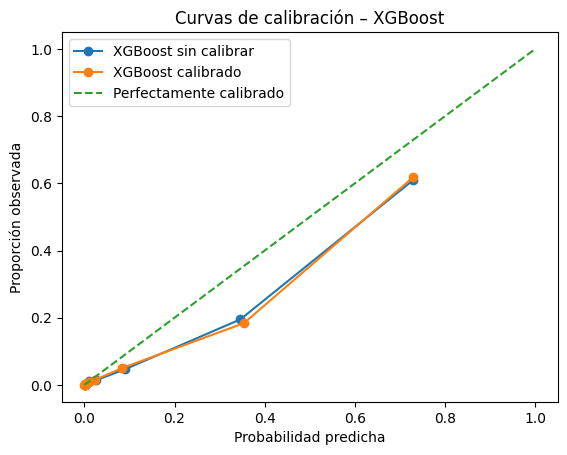

In [103]:
# Curva de calibración comparativa (antes vs después)
prob_true_cal, prob_pred_cal = calibration_curve(
    y_test,
    y_prob_xgb_cal,
    n_bins=10,
    strategy="quantile"
)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost sin calibrar')
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='XGBoost calibrado')
plt.plot([0,1], [0,1], linestyle='--', label='Perfectamente calibrado')
plt.xlabel("Probabilidad predicha")
plt.ylabel("Proporción observada")
plt.title("Curvas de calibración – XGBoost")
plt.legend()
plt.show()


**y_prob_base:** contiene las probabilidades del modelo RF base con las variables clínicas  
**y_prob:** contiene las probabilidades del modelo RF sin las variables clínicas  
**y_prob_cal:** contiene las probabilidades del modelo RF calibrado  
**y_prob_log:** contiene las probabilidades del modelo de regresion logística (usa el mismo procesador de RF)  
**y_prob_xgb:** contiene las probabilidades del modelo XGBoost (usa el mismo procesador de RF)
**y_prob_xgb_cal:** contiene las probabilidades del modelo XGBoost calibrado

In [104]:
# Función para calcular métricas

def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    
    return {
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Recall": recall_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "Brier Score": brier_score_loss(y_true, y_prob)
    }

# Diccionario con modelos y probabilidades
models = {
    "Random Forest (base)": y_prob_base,
    "Random Forest (sin variables diagnósticas)": y_prob,
    "Random Forest calibrado": y_prob_cal,
    "Regresión Logística": y_prob_log,
    "Regresión Logística calibrada": y_prob_log_cal,
    "XGBoost": y_prob_xgb,
    "XGBoost calibrado": y_prob_xgb_cal
}

# Construcción de la tabla
results = []

for model_name, y_prob_model in models.items():
    metrics = compute_metrics(y_test, y_prob_model)
    metrics["Modelo"] = model_name
    results.append(metrics)

# DataFrame final
results_df = pd.DataFrame(results)
results_df = results_df.set_index("Modelo")

# Redondear para presentación
results_df = results_df.round(3)

results_df


,ROC-AUC,Recall,Precision,Accuracy,F1-score,Brier Score
Modelo,,,,,,
Random Forest (base),1.000,0.993,0.926,0.992,0.959,0.011
Random Forest (sin variables diagnósticas),0.948,0.924,0.369,0.854,0.527,0.112
Random Forest calibrado,0.947,0.507,0.700,0.937,0.588,0.046
Regresión Logística,0.945,0.959,0.317,0.815,0.477,0.131
Regresión Logística calibrada,0.945,0.595,0.592,0.928,0.593,0.054
XGBoost,0.955,0.678,0.620,0.935,0.647,0.045
XGBoost calibrado,0.956,0.679,0.636,0.938,0.657,0.045


**SHAP**

In [44]:
import shap

def get_preprocessed_data_and_feature_names(pipeline, X):
    """
    Devuelve:
    - X_transformado (DataFrame)
    - nombres de las variables tras el preprocesamiento
    """
   # 1. Extraer el preprocesador del pipeline
    preprocessor = pipeline.named_steps['preprocessor']

    # 2. Transformar los datos
    X_transformed = preprocessor.transform(X)

    # 3. Obtener nombres de las variables transformadas
    feature_names = preprocessor.get_feature_names_out()

    return X_transformed, feature_names


c:\Users\PERSONAL\OneDrive - UNIR\Segundo Cuatrimestre\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
# Preparar datos
X_train_trans, feature_names = get_preprocessed_data_and_feature_names(
    rf_pipeline,
    X_train
)

# Crear explainer y valores SHAP
rf_model = rf_pipeline.named_steps['model']

explainer = shap.TreeExplainer(
    rf_model,
    feature_perturbation="interventional"
)


np.random.seed(42)

idx = np.random.choice(
    X_train_trans.shape[0],
    size=1000,
    replace=False
)

X_shap = X_train_trans[idx]


shap_values = explainer.shap_values(X_shap)
shap_values_pos = shap_values[1]

c:\Users\PERSONAL\OneDrive - UNIR\Segundo Cuatrimestre\env\Lib\site-packages\shap\explainers\_tree.py:254: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


In [47]:
shap_values = explainer.shap_values(X_shap)
shap_values_pos = shap_values[1]

print(shap_values_pos.shape)
print(X_shap.shape)



(44, 2)
(1000, 44)


In [53]:

def compute_shap_random_forest(
    trained_pipeline,
    X_train,
    sample_size=1000,
    random_state=42
):
    """
    Calcula SHAP values correctamente para un Random Forest entrenado
    dentro de un Pipeline con ColumnTransformer.

    Parámetros
    ----------
    trained_pipeline : sklearn Pipeline ya entrenado
    X_train : DataFrame original (sin transformar)
    sample_size : número de observaciones a explicar (submuestreo)
    random_state : semilla para reproducibilidad

    Retorna
    -------
    shap_values : array (n_samples, n_features)
    X_shap : array transformado usado para SHAP
    feature_names : nombres de las variables transformadas
    """

    # 1. Extraer preprocesador y modelo
    preprocessor = trained_pipeline.named_steps['preprocessor']
    model = trained_pipeline.named_steps['model']

    # 2. Transformar X_train
    X_train_trans = preprocessor.transform(X_train)

    # 3. Obtener nombres de variables
    num_features = preprocessor.transformers_[0][2]

    cat_pipeline = preprocessor.transformers_[1][1]
    cat_features = preprocessor.transformers_[1][2]

    ohe = cat_pipeline.named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(cat_features)

    feature_names = np.concatenate([num_features, cat_feature_names])

    # 4. Submuestreo (SHAP es costoso)
    np.random.seed(random_state)

    idx = np.random.choice(
        X_train_trans.shape[0],
        size=min(sample_size, X_train_trans.shape[0]),
        replace=False
    )

    X_shap = X_train_trans[idx]

    # 5. SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)

     # 6. Seleccionar clase positiva (diabetes = 1)
    if shap_values.ndim == 3:
        shap_values = shap_values[:, :, 1]

    # 7. Chequeo final
    assert shap_values.shape == X_shap.shape, (
        f"Mismatch final: SHAP {shap_values.shape} vs X {X_shap.shape}"
    )

    return shap_values, X_shap, feature_names


In [54]:
shap_values, X_shap, feature_names = compute_shap_random_forest(
    rf_pipeline,
    X_train,
    sample_size=1000
)


C:\Users\PERSONAL\AppData\Local\Temp\ipykernel_15120\1430022389.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


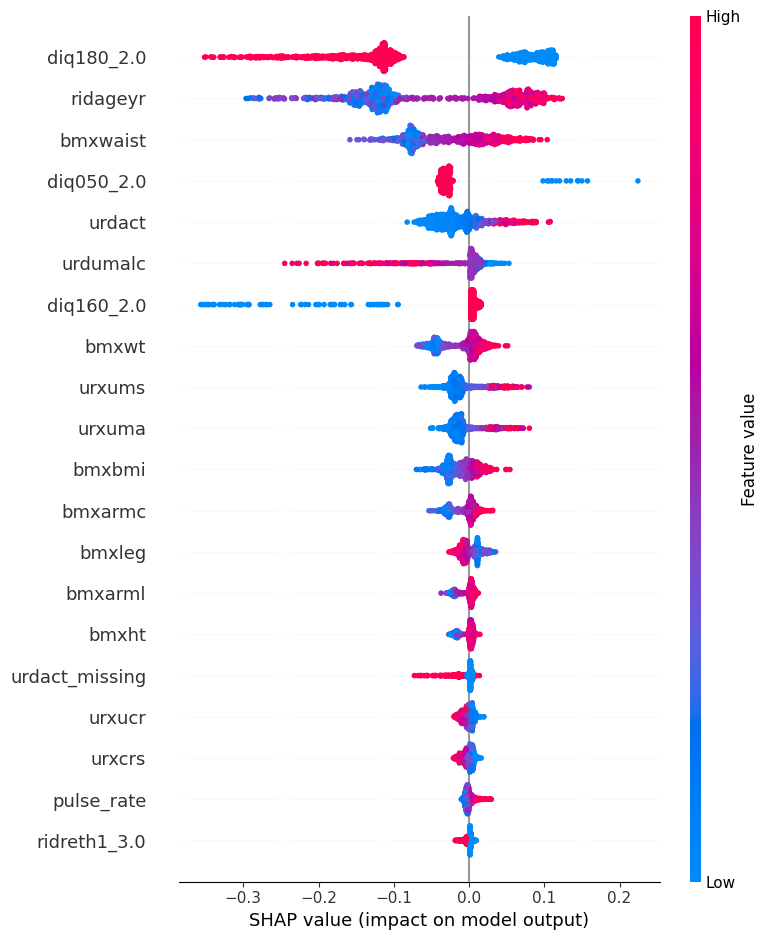

In [55]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    show=True
)


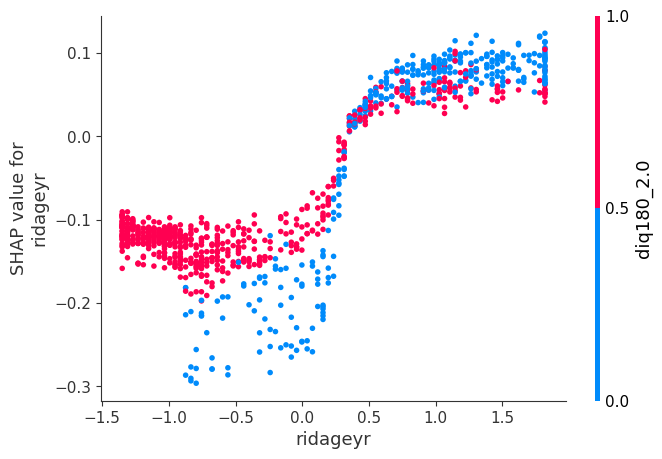

In [58]:
# SHAP dependence plots (relación variables-riesgo)
shap.dependence_plot(
    "ridageyr",
    shap_values,
    X_shap,
    feature_names=feature_names,
    interaction_index="auto"
)



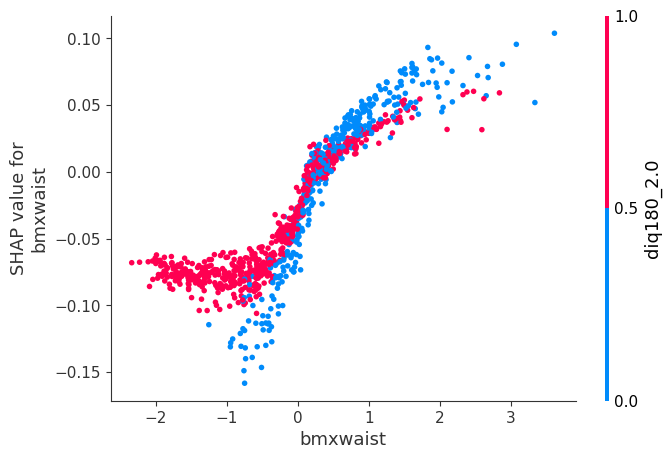

In [60]:
# PERÍMETRO DE CINTURA
shap.dependence_plot(
    "bmxwaist",
    shap_values,
    X_shap,
    feature_names=feature_names,
    interaction_index="auto"
)



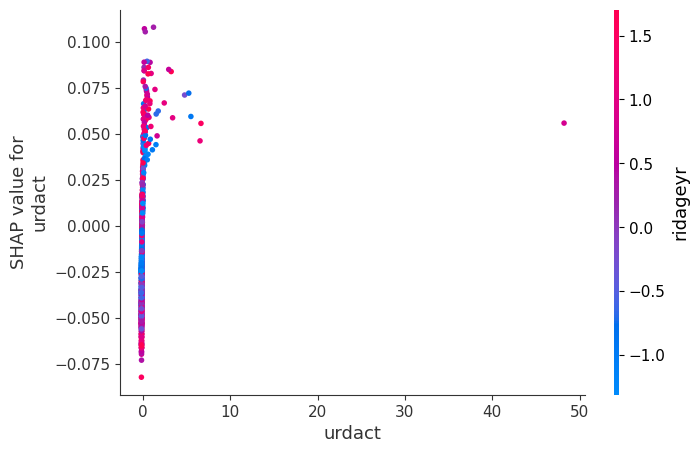

In [61]:
# URDACT (albuminuria)
shap.dependence_plot(
    "urdact",
    shap_values,
    X_shap,
    feature_names=feature_names,
    interaction_index="auto"
)


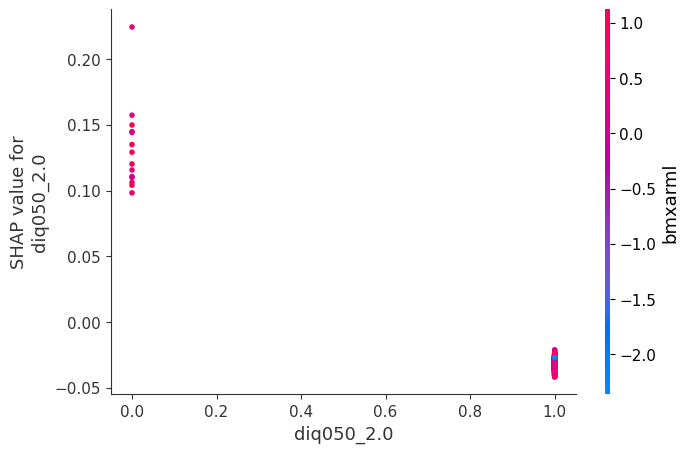

In [62]:
# URDACT (albuminuria)
shap.dependence_plot(
    "diq050_2.0",
    shap_values,
    X_shap,
    feature_names=feature_names,
    interaction_index="auto"
)

In [65]:

# Convertimos a arrays para indexar bien
y_test_array = np.array(y_test)
y_prob_array = np.array(y_prob)

# Individuo A: alto riesgo y diabético
idx_high_risk = np.where((y_test_array == 1) & (y_prob_array > 0.8))[0][0]

# Individuo B: bajo riesgo y no diabético
idx_low_risk = np.where((y_test_array == 0) & (y_prob_array < 0.2))[0][0]

print("Índice individuo alto riesgo:", idx_high_risk)
print("Índice individuo bajo riesgo:", idx_low_risk)


Índice individuo alto riesgo: 12
Índice individuo bajo riesgo: 1


In [64]:
X_test_trans = preprocessor.transform(X_test)


In [ ]:
# Selección de individuos representativos

# Extraemos una fila (reshape obligatorio)
X_high = X_test_trans[idx_high_risk].reshape(1, -1)
X_low = X_test_trans[idx_low_risk].reshape(1, -1)

# SHAP values
shap_values_high = explainer(X_high)
shap_values_low = explainer(X_low)


In [73]:
idx = 10 

shap_values_pos = shap_values[:, 1]


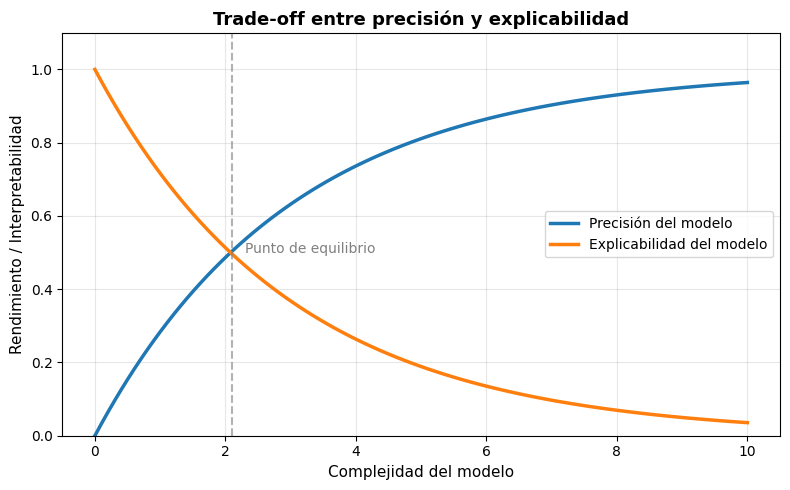

In [ ]:
###############################
# Otros
###############################

# Figura 3

# Crear datos simulados
x = np.linspace(0, 10, 100)
precision = 1 - np.exp(-x/3)  # Curva creciente (más complejidad -> más precisión)
explainability = np.exp(-x/3)  # Curva decreciente (más complejidad -> menos explicabilidad)

# Crear figura
plt.figure(figsize=(8,5))
plt.plot(x, precision, label="Precisión del modelo", linewidth=2.5, color='tab:blue')
plt.plot(x, explainability, label="Explicabilidad del modelo", linewidth=2.5, color='tab:orange')
plt.axvline(2.1, color='gray', linestyle='--', alpha=0.6)
plt.text(2.3, 0.5, "Punto de equilibrio", color='gray')

# Personalización
plt.title("Trade-off entre precisión y explicabilidad", fontsize=13, weight='bold')
plt.xlabel("Complejidad del modelo", fontsize=11)
plt.ylabel("Rendimiento / Interpretabilidad", fontsize=11)
plt.ylim(0, 1.1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Mostrar
plt.show()
